
# Introduction
>The goal of this report is to create a prototype mechanism for the salamander leg movement and understand the forces involved. In order for continuous progress to be made, the team decided to break down the problem into 2 main parts: the salamander body and salamander leg mechanisms. Here, we are focusing on only the leg mechanism.  Eventually once designs have progressed further, the number of actuators will potentially be reduced by connecting the motion of the spine to the movement of the leg mechanism.

# Salamander Leg Motion
>The final system will comprise of a 4 legged-salamnander like robot with 4 identical legs. In this report, the initial leg motion was simulated in pynamics. The team adapted the triple pendulum example to get familiar with the dynamics of the system.

In [1]:
%matplotlib inline

In [2]:
use_constraints = True

In [3]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
from pynamics.constraint import AccelerationConstraint
import pynamics.integration
import numpy
import sympy
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [4]:
system = System()
pynamics.set_system(__name__,system)

## Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.
> Link lengths are calculated assuming a body width* of 4 cm. Vertical travel of half body-width was decided on, with final angle of contact at pi/3 radians to horizon.<br>Masses are estimated at 2g per cm.<br>Torque was etimated in system kinematics.<br><br>*Body width estimates are based on existing models and expected project scale; subject to change.

In [5]:
lA = Constant(.05,'lA',system)
lB = Constant(.03,'lB',system)
lC = Constant(.03,'lC',system)

mA = Constant(.010,'mA',system)
mB = Constant(.06,'mB',system)
mC = Constant(.06,'mC',system)

g = Constant(9.81,'g',system)
b = Constant(8,'b',system)
k = Constant(8,'k',system)

preload1 = Constant(0*pi/180,'preload1',system)
preload2 = Constant(-90*pi/180,'preload2',system)
preload3 = Constant(-80*pi/180,'preload3',system)

torque = Constant(-20,'torque',system)
freq = Constant(0.05,'freq',system)

In [6]:
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)

initialvalues = {}
initialvalues[qA]=0*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=-90*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=-80*pi/180
initialvalues[qC_d]=0*pi/180

statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [7]:
N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)

system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(A,[0,0,1],qB,system)
C.rotate_fixed_axis(B,[0,0,1],qC,system)

In [8]:
pNA=0*N.x
pAB=pNA+lA*A.x
pBC = pAB + lB*B.x
pCtip = pBC + lC*C.x

In [9]:
wNA = N.get_w_to(A)
wAB = A.get_w_to(B)
wBC = B.get_w_to(C)

vCtip = pCtip.time_derivative(N,system)

## Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame.
>Inertias are calculated for the expected shape of each link, a cubiod and above mention values for lengths and masses.<br>Center of masses are assumed to be at the center of each link, as is expected.

In [10]:
Ixx_A = Constant(3.5417e-07,'Ixx_A',system)
Iyy_A = Constant(2.4167e-06,'Iyy_A',system)
Izz_A = Constant(2.1047e-06,'Izz_A',system)
Ixx_B = Constant(3.5417e-07,'Ixx_B',system)
Iyy_B = Constant(1.0833e-06,'Iyy_B',system)
Izz_B = Constant(7.7083e-07,'Izz_B',system)
Ixx_C = Constant(3.5417e-07,'Ixx_C',system)
Iyy_C = Constant(1.0833e-06,'Iyy_C',system)
Izz_C = Constant(7.7083e-07,'Izz_C',system)

IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)

pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x
pCcm=pBC+lC/2*C.x

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)

## Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint.
>Gravity was added. Rotational springs and dampers were also added. The team used trial and error to refine the tpring and damper coefficients until the estimated values achieved the desired motion.

In [11]:
p = sympy.Piecewise((0, system.t < 0), (torque, system.t <= 1), (0, True))
# system.addforce(p*A.z,wNA)
system.addforce(torque*sympy.cos(freq*2*sympy.pi*system.t)*A.z,wNA)
system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)

system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
system.add_spring_force1(k,(qB-preload2)*A.z,wAB)
system.add_spring_force1(k,(qC-preload3)*B.z,wBC)

system.addforcegravity(-g*N.y)

## Constraints: 
>pNA is attached to the newtonian frame and pCtip is fixed using contraints. Both these constraints represent points that will be attatched to the body of the robot.

In [12]:
if use_constraints:
    eq = []
    eq.append(pCtip)
    eq_d=[item.time_derivative() for item in eq]
    eq_dd=[item.time_derivative() for item in eq_d]
    eq_dd_scalar = []
    eq_dd_scalar.append(eq_dd[0].dot(N.y))
    eq_dd_scalar.append(eq_dd[0].dot(N.x))
    constraint = AccelerationConstraint(eq_dd_scalar)
    system.add_constraint(constraint)


## Solution:
> By solving for f=ma, integrating, plotting, and animating the results, we could see the results of our system dynamics. As shown in the following videos, the leg is constrainted at two different points (at the pNA and pCtip). The leg oscillates up and down and those two points are fixed.

In [13]:
f,ma = system.getdynamics()

func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

2022-03-06 17:24:36,441 - pynamics.system - INFO - getting dynamic equations
2022-03-06 17:24:36,949 - pynamics.system - INFO - solving a = f/m and creating function
2022-03-06 17:24:37,116 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-03-06 17:24:37,460 - pynamics.system - INFO - done solving a = f/m and creating function
2022-03-06 17:24:37,461 - pynamics.system - INFO - calculating function for lambdas


In [14]:
tol = 1e-5

tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [15]:
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

2022-03-06 17:24:37,684 - pynamics.integration - INFO - beginning integration
2022-03-06 17:24:37,685 - pynamics.system - INFO - integration at time 0000.00
2022-03-06 17:24:38,231 - pynamics.integration - INFO - finished integration


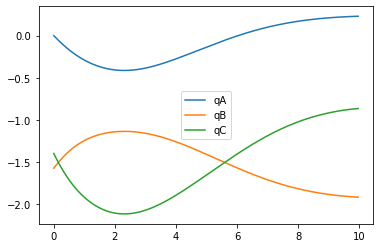

In [16]:
plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

2022-03-06 17:24:38,501 - pynamics.output - INFO - calculating outputs
2022-03-06 17:24:38,515 - pynamics.output - INFO - done calculating outputs


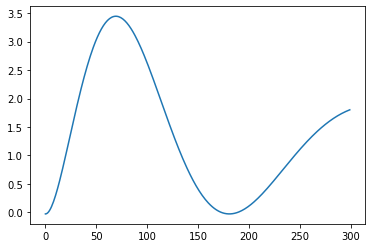

In [17]:
KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

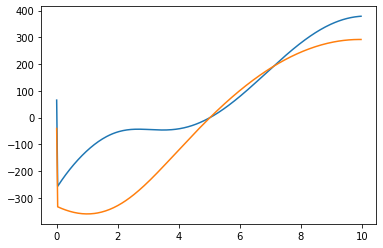

In [18]:
if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)

## Tuning: 
>The damper term b was adjusted to show how the system would look like if it settled. A high b term was used to see the system, settle faster.

2022-03-06 17:24:38,942 - pynamics.integration - INFO - beginning integration
2022-03-06 17:24:39,026 - pynamics.system - INFO - integration at time 0000.12
2022-03-06 17:24:39,266 - pynamics.integration - INFO - finished integration
2022-03-06 17:24:39,312 - pynamics.output - INFO - calculating outputs
2022-03-06 17:24:39,326 - pynamics.output - INFO - done calculating outputs


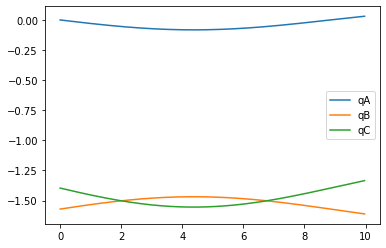

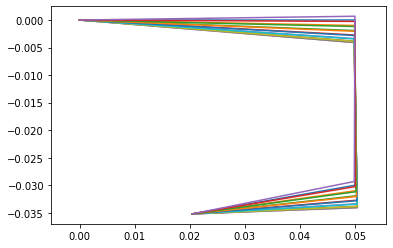

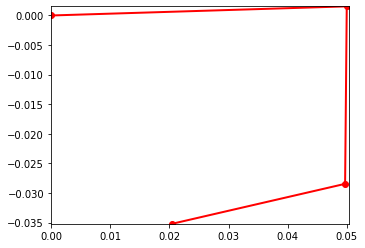

In [19]:
b = Constant(100,'b',system)
k = Constant(8,'k',system)
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))

plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

points = [pNA,pAB,pBC,pCtip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)

points_output.animate(fps = fps,movie_name = 'leg4days.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())


## (Optional): Adjust joint stiffness values so that your system looks more realistic
>Using trial and error, the damping coefficient was tuned to achieve desired motions. These values will be tested for in the future in actual experimentations that will measure the actual values for the parameters, but for now the b and k values of 8 demonstrate the motion that we expect to see.

2022-03-06 17:25:02,977 - pynamics.integration - INFO - beginning integration
2022-03-06 17:25:03,443 - pynamics.system - INFO - integration at time 0005.40
2022-03-06 17:25:03,591 - pynamics.integration - INFO - finished integration
2022-03-06 17:25:03,618 - pynamics.output - INFO - calculating outputs
2022-03-06 17:25:03,633 - pynamics.output - INFO - done calculating outputs


<AxesSubplot:>

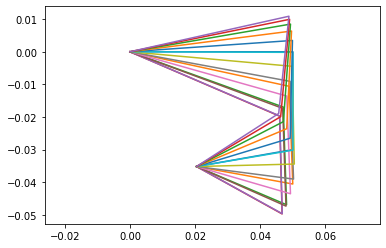

In [20]:
b = Constant(8,'b',system)
k = Constant(8,'k',system)
states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))
points = [pNA,pAB,pBC,pCtip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)


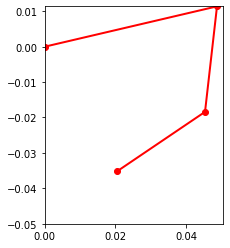

In [21]:
points_output.animate(fps = fps,movie_name = 'leg4days.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())

# Salamander Spine Motion
>The team then adapted the triple pendulum example to demonstrate the spine motion that would occur. The procedure that was used to develop this model is essentially the same that was done for the leg motion

## Scale: Ensure your system is using SI units. You should be specifying lengths in meters (so millimeters should be scaled down to the .001 range), forces in Newtons, and radians (not degrees), and masses in kg. You may make educated guesses about mass for now.
> The salamander is around 20cm long. This length was divided up into 3 different segments making the link lengthes around 7cm and 6cm, but these numbers will evolve as the system design gets further fleshed out. The mass is in kg and is basically made by dividing the mass of the salamander into three main sections. The mass of a salamander is aroud 60 grams so divided by three gives each link length around 20 grams.

In [22]:
system = System()
pynamics.set_system(__name__,system)

lA = Constant(.07,'lA',system)
lB = Constant(.06,'lB',system)
lC = Constant(.07,'lC',system)

mA = Constant(.02,'mA',system)
mB = Constant(.02,'mB',system)
mC = Constant(.02,'mC',system)

g = Constant(9.81,'g',system)
b = Constant(1e1,'b',system)
k = Constant(1e1,'k',system)

preload1 = Constant(-90*pi/180,'preload1',system)
preload2 = Constant(0*pi/180,'preload2',system)
preload3 = Constant(0*pi/180,'preload3',system)



## Define Inertias: Add a center of mass and a particle or rigid body to each rotational frame.
>Inertias are calculated for the expected shape of each link, a cubiod and above mention values for lengths and masses.<br>Center of masses are assumed to be at the center of each link.

In [23]:
Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)

torque = Constant(1e1,'torque',system)
freq = Constant(5e-1,'freq',system)

qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)

initialvalues = {}
initialvalues[qA]=-90*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=0*pi/180
initialvalues[qC_d]=0*pi/180

statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

N = Frame('N',system)
A = Frame('A',system)
B = Frame('B',system)
C = Frame('C',system)

system.set_newtonian(N)

A.rotate_fixed_axis(N,[0,0,1],qA,system)
B.rotate_fixed_axis(A,[0,0,1],qB,system)
C.rotate_fixed_axis(B,[0,0,1],qC,system)

pNA=0*N.x
pAB=pNA+lA*A.x
pBC = pAB + lB*B.x
pCtip = pBC + lC*C.x

pAcm=pNA+lA/2*A.x
pBcm=pAB+lB/2*B.x
pCcm=pBC+lC/2*C.x

wNA = N.get_w_to(A)
wAB = A.get_w_to(B)
wBC = B.get_w_to(C)

vCtip = pCtip.time_derivative(N,system)

IA = Dyadic.build(A,Ixx_A,Iyy_A,Izz_A)
IB = Dyadic.build(B,Ixx_B,Iyy_B,Izz_B)
IC = Dyadic.build(C,Ixx_C,Iyy_C,Izz_C)

BodyA = Body('BodyA',A,pAcm,mA,IA,system)
BodyB = Body('BodyB',B,pBcm,mB,IB,system)
BodyC = Body('BodyC',C,pCcm,mC,IC,system)

## Add Forces: Add the acceleration due to gravity. Add rotational springs in the joints (using k=0 is ok for now) and a damper to at least one rotational joint.
>Since this is a planar view of the system looking from the top down, gravity was added in the z direction. Rotational springs and dampers were also added. The team used trial and error to refine the spring and damper coefficients until the estimated values achieved the desired motion.

In [24]:
system.addforce(torque*sympy.sin(freq*2*sympy.pi*system.t)*B.z,wAB)
system.addforce(-torque*sympy.sin(freq*2*sympy.pi*system.t)*C.z,wBC) #remove -ve sign for C-shape motion instead of S-shape.

system.addforce(-b*wNA,wNA)
system.addforce(-b*wAB,wAB)
system.addforce(-b*wBC,wBC)

system.add_spring_force1(k,(qA-preload1)*N.z,wNA) 
system.add_spring_force1(k,(qB-preload2)*A.z,wAB)
system.add_spring_force1(k,(qC-preload3)*B.z,wBC)

system.addforcegravity(-g*N.z)

## Constraints: 
>pNA is attached to the newtonian frame. This is temporary. The next phase of modelling system dynamics would be to make it free to move and only have forces on the system when the legs are in contact with the ground plane.

In [25]:
if use_constraints:
    eq = []
    eq.append(pCtip)
    eq_d=[item.time_derivative() for item in eq]
    eq_dd=[item.time_derivative() for item in eq_d]
    eq_dd_scalar = []
    eq_dd_scalar.append(eq_dd[0].dot(N.x))
    constraint = AccelerationConstraint(eq_dd_scalar)
    system.add_constraint(constraint)

## Solution:
> By solving for f=ma, integrating, plotting, and animating the results, we could see the results of our system dynamics. As shown in the following videos, the spine is constrained at the top and then the body moves side to side. This is very similar to the mechanics of the triple pendulum.

2022-03-06 17:25:23,189 - pynamics.system - INFO - getting dynamic equations
2022-03-06 17:25:23,846 - pynamics.system - INFO - solving a = f/m and creating function
2022-03-06 17:25:23,913 - pynamics.system - INFO - substituting constrained in Ma-f.
2022-03-06 17:25:23,999 - pynamics.system - INFO - done solving a = f/m and creating function
2022-03-06 17:25:24,001 - pynamics.system - INFO - calculating function for lambdas
2022-03-06 17:25:24,003 - pynamics.integration - INFO - beginning integration
2022-03-06 17:25:24,003 - pynamics.system - INFO - integration at time 0000.00
2022-03-06 17:25:24,493 - pynamics.system - INFO - integration at time 0007.81
2022-03-06 17:25:24,617 - pynamics.integration - INFO - finished integration
2022-03-06 17:25:24,685 - pynamics.output - INFO - calculating outputs
2022-03-06 17:25:24,698 - pynamics.output - INFO - done calculating outputs


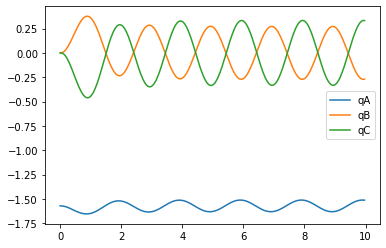

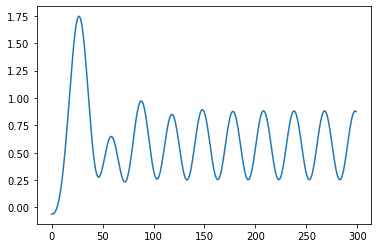

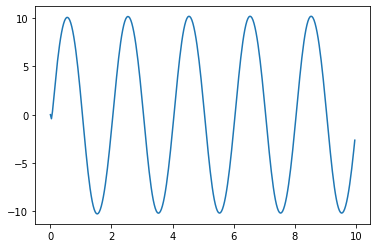

In [26]:
f,ma = system.getdynamics()

func1,lambda1 = system.state_space_post_invert(f,ma,return_lambda = True)

tol = 1e-7
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

states=pynamics.integration.integrate(func1,ini,t,rtol=tol,atol=tol, args=({'constants':system.constant_values},))
plt.figure()
artists = plt.plot(t,states[:,:3])
plt.legend(artists,['qA','qB','qC'])

KE = system.get_KE()
PE = system.getPEGravity(pNA) - system.getPESprings()
energy_output = Output([KE-PE],system)
energy_output.calc(states,t)
energy_output.plot_time()

if use_constraints:
    lambda2 = numpy.array([lambda1(item1,item2,system.constant_values) for item1,item2 in zip(t,states)])
    plt.figure()
    plt.plot(t, lambda2)
    


## Tuning: 
>The b and k terms were tuned using trial and error to get the results that we hope to see in an actuated spine motion until the following values were found that matched the desired motion.

2022-03-06 17:25:25,219 - pynamics.output - INFO - calculating outputs
2022-03-06 17:25:25,237 - pynamics.output - INFO - done calculating outputs


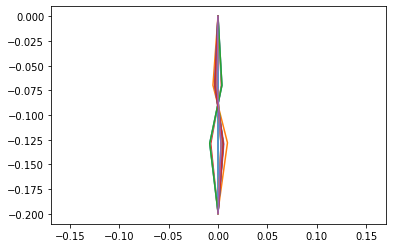

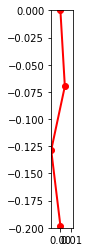

In [27]:
points = [pNA,pAB,pBC,pCtip]
points_output = PointsOutput(points,system)
y = points_output.calc(states,t)
points_output.plot_time(20)
points_output.animate(fps = fps,movie_name = 'Ssssssspine.mp4',lw=2,marker='o',color=(1,0,0,1),linestyle='-')

from matplotlib import animation, rc
from IPython.display import HTML
HTML(points_output.anim.to_html5_video())